# One Jet At A Time

Maybe it's useful to have a single-jet classifier?

Is it even possible to classify jets based on $p_T, \eta, \phi$ alone?

In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import roc_curve

import tools

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

Using TensorFlow backend.


Load ntuple, get the data we need from the file

In [2]:
s_table = tools.open_file(filename, sort_by="tag")

sorting data by tag


Filters

In [3]:
nj4 = s_table.njets>=4   # >=4 jets exist
nb4 = s_table.nbjets>=4  # >=4 b jets really exist
nt3 = s_table.nbtags==3  # 3 b tags
nb4nt3 = nb4 & nt3  # >=4 bjets, exactly 3 are tagged
nj4nt3 = nj4 & nt3  # >=4 jets, exactly 3 are tagged

events = s_table[nj4nt3]
n_events = len(events)
print(n_events)

pt = events["resolved_lv"].pt
eta = events["resolved_lv"].eta
phi = events["resolved_lv"].phi
truth = events["truth"]

312386


Flatten everything so we just have jets, no longer organized as events

In [4]:
# also reshape so we have arrays that look like [[1], [2], [3], ...]
pt = pt.flatten().reshape(-1, 1)
eta = eta.flatten().reshape(-1, 1)
phi = phi.flatten().reshape(-1, 1)
truth = truth.flatten().reshape(-1, 1)

Then prepare for keras stuff

In [5]:
# print an example
i=1
print("This is a", bool(truth[i]), "b-jet:")
print("pt", pt[i], "eta", eta[i], "phi", phi[i])
print()

This is a True b-jet:
pt [55.581104] eta [2.3661427] phi [0.85040945]



In [6]:
# scale data to be keras-friendly
scaler_pt = StandardScaler()
scaler_eta = StandardScaler()
scaler_phi = StandardScaler()

# s for scaled
s_pt = scaler_pt.fit_transform(pt)
s_eta = scaler_eta.fit_transform(eta)
s_phi = scaler_phi.fit_transform(phi)

# stack pt, eta, phi for input into model
s_in = np.column_stack((s_pt, s_eta, s_phi))

Split data into training, validation, and testing subsets

In [7]:
# split missed_jet into training, validation, testing subsets
train, val, test = tools.splitTVT(truth, trainfrac=0.7, testfrac=0.2)

I experimented a little with having different layers and this ended up being the best trade off of speed to quality

In [8]:
model = Sequential()
model.add(Dense(3, input_dim=3, kernel_initializer='normal', activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# compile model
optimizer = Adam(lr=5e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

In [9]:
history = model.fit(s_in[train], truth[train],
                    validation_data=(s_in[val], truth[val]),
                    epochs = 100, batch_size = 2000, verbose = 1)

Train on 1249483 samples, validate on 178499 samples
Epoch 1/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.6854 - acc: 0.6248 - val_loss: 0.6757 - val_acc: 0.6231
Epoch 2/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.6614 - acc: 0.6247 - val_loss: 0.6479 - val_acc: 0.6231
Epoch 3/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.6369 - acc: 0.6247 - val_loss: 0.6282 - val_acc: 0.6231
Epoch 4/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.6194 - acc: 0.6247 - val_loss: 0.6124 - val_acc: 0.6231
Epoch 5/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.6061 - acc: 0.6335 - val_loss: 0.6020 - val_acc: 0.6964
Epoch 6/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5989 - acc: 0.7221 - val_loss: 0.5971 - val_acc: 0.7320
Epoch 7/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5949 - acc: 0.73

1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5475 - acc: 0.7342 - val_loss: 0.5478 - val_acc: 0.7339
Epoch 59/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5475 - acc: 0.7342 - val_loss: 0.5477 - val_acc: 0.7338
Epoch 60/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5475 - acc: 0.7342 - val_loss: 0.5477 - val_acc: 0.7339
Epoch 61/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5474 - acc: 0.7342 - val_loss: 0.5478 - val_acc: 0.7339
Epoch 62/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5474 - acc: 0.7342 - val_loss: 0.5477 - val_acc: 0.7338
Epoch 63/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5474 - acc: 0.7343 - val_loss: 0.5477 - val_acc: 0.7337
Epoch 64/100
1249483/1249483 [==============================] - 2s 1us/step - loss: 0.5474 - acc: 0.7343 - val_loss: 0.5476 - val_acc: 0.7337
Epoch 65/100
124948

In [10]:
selection = model.predict_classes(s_in)

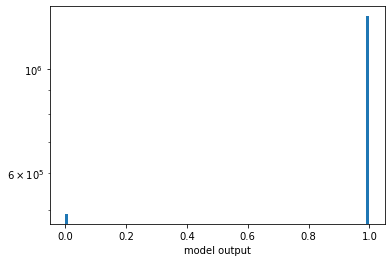

In [11]:
plt.hist(selection, bins=100)
plt.yscale('log')
plt.xlabel("model output")
plt.show()

In [17]:
selection = selection.flatten()
truth = truth.flatten()

n = len(selection)

correct = np.logical_and(selection, truth.flatten())
n_correct = np.count_nonzero(correct)

percent_correct = n_correct/n*100
print(percent_correct)

54.187476925472986


Well it seems that was a bit of waste of time. Good try anyway?